##  Programming Exercise: Spam Filter

### DS 5220 - Omer Seyfeddin Koc

A spam filter is a computer program that classifies e-mail messages as either spam (unwanted) or ham (wanted). The spam filter maintains a set of features. A feature is a characteristic of messages that the spam filter can use to distinguish ham from spam. A feature could be simply the presence of a word in the message, for example, ”the message contains the word ’lottery’”, and it could be much more complex/powerful, for example, ”the subject line is all capitals” or ”the message body mentions many Internet domains”. <br><br> Given (1) a set of features, (2) a set of messages known to be ham, and (3) a set of messages known to be spam, the spam filter learns how to classify incoming messages as ham or spam. In this exercise we are going to train a spam filter using the Apache SpamAssassin public mail corpus.


## 1. Download the files / 2. Unzip the datasets and familiarize yourself with the data format

In [1]:
# import required library
import os
import io
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import email
import os
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
nltk.download('stopwords')
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omerkoc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Use Python’s email module to parse the email messages 

In [2]:
import email
from bs4 import BeautifulSoup

def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = email.message_from_bytes(f.read())
    # Get email headers
    subject = msg.get('Subject')
    # Read email’s body
    body = str(msg.get_payload())
    # Remove HTML tags
    body = BeautifulSoup(body).get_text()
    return subject, body

In [3]:
import os
import pandas as pd

# Initialize an empty DataFrame with two columns: 'message' and 'class_'
data = pd.DataFrame({'message': [], 'class_': []})

# Iterate through every file in the 'easy_ham' directory and append it to the DataFrame with class label 0 (ham)
ham_dir = 'easy_ham'
for filename in os.listdir(ham_dir):
    filepath = os.path.join(ham_dir, filename)
    subject, body = parse_email(filepath)
    # Append the DataFrame with messages from the 'easy_ham' directory and assign class label 0 (ham)
    data = pd.concat([data, pd.DataFrame({'message': [body], 'class_': [0]})], ignore_index=True)

# Iterate through every file in the 'spam' directory and append it to the DataFrame with class label 1 (spam)
spam_dir = 'spam'
for filename in os.listdir(spam_dir):
    filepath = os.path.join(spam_dir, filename)
    subject, body = parse_email(filepath)
    # Append the DataFrame with messages from the 'spam' directory and assign class label 1 (spam)
    data = pd.concat([data, pd.DataFrame({'message': [body], 'class_': [1]})], ignore_index=True)

/Users/omerkoc/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/omerkoc/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [4]:
# Display the first 5 rows of the DataFrame
data.head()

,message,class_
0,"In a message dated 9/24/2002 11:24:58 AM, jame...",0.0
1,"Hiya, I always seem to get errors when I do an...",0.0
2,I don't know how one can expect better and mor...,0.0
3,Tim Peters wrote:\n> I've run no experiments o...,0.0
4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0.0


In [5]:
# Counts the number of occurrences of each unique value in the 'class_' column of the DataFrame
# The correctness of the data entry is checked by looking at the values here.
data['class_'].value_counts()

0.0    2501
1.0     501
Name: class_, dtype: int64

## 4. Apply text preprocessing techniques to convert each email into a feature vector.

In [6]:
# Apply text preprocessing techniques
def text_process(text):
    # Replace URLs with 'URL'
    text = re.sub(r'http\S+', 'URL', text)
    # Tokenize text into words
    text = text.split()
    # Remove stop words
    text = [word for word in text if word.lower() not in stopwords.words('english')]
    # Join words back into text
    text = ' '.join(text)
    return text

# Applies the text_process function to the 'message' column of the DataFrame
# text_process function converts text to lowercase, removes URLs, removes punctuations, 
# tokenizes the text into words, removes stop words, and joins the remaining words back into text.
data['message'] = data['message'].apply(text_process)

# Display the first 5 rows of the data
data.head()

,message,class_
0,"message dated 9/24/2002 11:24:58 AM, jamesr@be...",0.0
1,"Hiya, always seem get errors ""apt update"", pro...",0.0
2,know one expect better secure code community s...,0.0
3,Tim Peters wrote: > I've run experiments train...,0.0
4,"10:34 -0700 8/28/02, Jim Whitehead wrote: > Gr...",0.0


In [7]:
import pandas as pd
# Create a new DataFrame containing preprocessed text messages
text = pd.DataFrame(data['message'])

# Create a new DataFrame containing the corresponding class labels for each message
class_ = pd.DataFrame(data['class_'])

### Vectorizer

Count Vectorizer or TF-IDF Vectorizer can be used to turn words into vectors. TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert each email into a feature vector.
# Create TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text['message'])

## 5. Split the emails into training and test sets.

In [9]:
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

from sklearn.feature_extraction.text import CountVectorizer

# Convert text messages to a matrix of token counts
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data['message'])

#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['class_'], test_size=0.2, random_state=1)

## 6. Try out several classifiers (e.g., Naive Bayes, KNN, logistic regression) and see if you can build a great spam classifier, with both high recall and high precision.

In [10]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

### a) Linear SVC

In [11]:
# Linear SVC
lsvc = LinearSVC(verbose=0,random_state=1)
lsvc.fit(X_train, y_train)
lsvc_score = lsvc.score(X_test, y_test)

# Make predictions on the test set
y_pred = lsvc.predict(X_test)

# Calculate recall and precision scores
lsvc_recall = recall_score(y_test, y_pred)
lsvc_precision = precision_score(y_test, y_pred)
lsvc_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", lsvc_accuracy)
print("Score: ", lsvc_score)
print("Recall: ", lsvc_recall)
print("Precision: ", lsvc_precision)

Accuracy: 0.9500831946755408
Score:  0.9500831946755408
Recall:  0.7058823529411765
Precision:  1.0


### b) K-Nearest Neighbors

In [12]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_score=knn.score(X_test, y_test)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate recall and precision scores
knn_recall = recall_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred)
knn_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", knn_accuracy)
print("Score: ", knn_score)
print("Recall: ", knn_recall)
print("Precision: ", knn_precision)

Accuracy: 0.6306156405990017
Score:  0.6306156405990017
Recall:  0.7254901960784313
Precision:  0.27611940298507465


/Users/omerkoc/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/omerkoc/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

### c) MultinomialNB

In [13]:
# import
from sklearn.naive_bayes import MultinomialNB

# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train, y_train)
nb_score=nb.score(X_test, y_test)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Calculate recall and precision scores
nb_recall = recall_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred)
nb_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", nb_accuracy)
print("Score: ", nb_score)
print("Recall: ", nb_recall)
print("Precision: ", nb_precision)

Accuracy: 0.956738768718802
Score:  0.956738768718802
Recall:  0.7549019607843137
Precision:  0.9871794871794872


### d) Decision Tree classifer

In [14]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier(random_state=1)

# Train Decision Tree Classifer
dtc = dtc.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtc.predict(X_test)
dtc_score=dtc.score(X_test, y_test)

# Calculate recall and precision scores
dtc_recall = recall_score(y_test, y_pred)
dtc_precision = precision_score(y_test, y_pred)
dtc_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", dtc_accuracy)
print("Score: ", dtc_score)
print("Recall: ", dtc_recall)
print("Precision: ", dtc_precision)

Accuracy: 0.9234608985024958
Score:  0.9234608985024958
Recall:  0.6862745098039216
Precision:  0.8333333333333334


### e) Logistic Regression

In [15]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear', penalty='l2',random_state=1)

# fit the model with data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_score=logreg.score(X_test, y_test)

# Calculate recall and precision scores
logreg_recall = recall_score(y_test, y_pred)
logreg_precision = precision_score(y_test, y_pred)
logreg_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", logreg_accuracy)
print("Score: ", logreg_score)
print("Recall: ", logreg_recall)
print("Precision: ", logreg_precision)

Accuracy: 0.9284525790349417
Score:  0.9284525790349417
Recall:  0.5784313725490197
Precision:  1.0


### f) Random Forest

In [16]:
# instantiate the model (using the default parameters)
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

# fit the model with data
y_pred = rf.predict(X_test)
rf_score=rf.score(X_test, y_test)

# Calculate recall and precision scores
rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", rf_accuracy)
print("Score: ", rf_score)
print("Recall: ", rf_recall)
print("Precision: ", rf_precision)

Accuracy: 0.9384359400998337
Score:  0.9384359400998337
Recall:  0.6372549019607843
Precision:  1.0


It is important that the recall value is higher for the email spam algorithm. The Recall value indicates how much of all genuine spam emails we correctly classify as spam. Therefore, it is important to minimize false negative results in the spam filtering system, namely the error of classifying a spam email as non-spam. The Precision value, on the other hand, shows how many false positive results are, and it is important to minimize the error of classifying a non-spam email as spam. However, considering the fact that most e-mails will not be spam, recall is more important than precision.<br> <br> That's why, I choosed MultinomialNB Model with 0.75 Recall and 0.98 Precision.

## 7. Show the confusion matrix and the classification report of your best classifier on both the training and the test set.

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Fit the best model on the training set
nb.fit(X_train, y_train)

# Generate predictions on the training and test sets
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

# Generate the confusion matrix and classification report for the training set
print("Training Set Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nTraining Set Classification Report:")
print(classification_report(y_train, y_train_pred))

# Generate the confusion matrix and classification report for the test set
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Set Confusion Matrix:
[[2001    1]
 [  77  322]]

Training Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      2002
         1.0       1.00      0.81      0.89       399

    accuracy                           0.97      2401
   macro avg       0.98      0.90      0.94      2401
weighted avg       0.97      0.97      0.97      2401

Test Set Confusion Matrix:
[[498   1]
 [ 25  77]]

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       499
         1.0       0.99      0.75      0.86       102

    accuracy                           0.96       601
   macro avg       0.97      0.88      0.92       601
weighted avg       0.96      0.96      0.95       601



## 8. How does the size of the training set affect the classifier’s performance? Train your classifier with different training set sizes, and show the learning curve (test set error vs. training set size).

In [18]:
from sklearn.metrics import accuracy_score
import numpy as np

# Define different training set sizes
train_sizes = np.arange(100, 2900, 200)

# Initialize list to store test set errors for each training set size
test_errors = []

# Train classifier and calculate test set errors for each training set size
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(features, data['class_'], train_size=size, random_state=1)
    nb = MultinomialNB(alpha=0.01)
    nb.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = nb.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    error = 1 - score  # Calculate test set error
    test_errors.append(error)
    print("Training Set Size:", size)
    print("Test Set Error:", error)
    print()

Training Set Size: 100
Test Set Error: 0.07236388697450036

Training Set Size: 300
Test Set Error: 0.061065877128053336

Training Set Size: 500
Test Set Error: 0.054756195043964784

Training Set Size: 700
Test Set Error: 0.05560382276281495

Training Set Size: 900
Test Set Error: 0.04804947668886772

Training Set Size: 1100
Test Set Error: 0.044689800210305

Training Set Size: 1300
Test Set Error: 0.042303172737955363

Training Set Size: 1500
Test Set Error: 0.04593874833555256

Training Set Size: 1700
Test Set Error: 0.04147465437788023

Training Set Size: 1900
Test Set Error: 0.042649727767695045

Training Set Size: 2100
Test Set Error: 0.04101995565410199

Training Set Size: 2300
Test Set Error: 0.03988603988603989

Training Set Size: 2500
Test Set Error: 0.03984063745019917

Training Set Size: 2700
Test Set Error: 0.039735099337748325



## Learning Curve

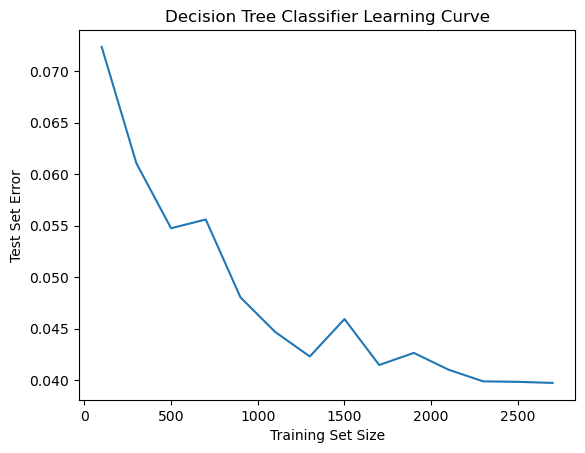

In [19]:
# Plot learning curve
import matplotlib.pyplot as plt

# Plot the learning curve
plt.plot(train_sizes, test_errors)
plt.xlabel('Training Set Size')
plt.ylabel('Test Set Error')
plt.title("Decision Tree Classifier Learning Curve")
plt.show()

## 9. Find the 10 tokens that are most indicative of the spam class

In [20]:
# Get the feature log probabilities from the trained Naive Bayes model
feature_log_prob = nb.feature_log_prob_

# Calculate the log ratios for each feature
log_ratios = feature_log_prob[1] - feature_log_prob[0]

# Get the indices of the top 10 features
top_indices = np.argsort(log_ratios)[-10:]

# Get the feature names corresponding to the top indices
feature_names = np.array(vectorizer.get_feature_names())
top_features = feature_names[top_indices]

# Print the top 10 most indicative features
print("Top 10 most indicative features of spam class:")
print(top_features)

Top 10 most indicative features of spam class:
['smokers' 'webcam' 'lenders' 'n9' 'kabila' 'prizemama' 'systemworks'
 'reservedif' 'havereceived' 'netnoteinc']


/Users/omerkoc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Thanks! 